In [61]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from utils import AngleData, invert_n

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
data_path = "data/angle_data_formatted.xlsx"

## Part 1: Calculations from Brewster's angle / Total internal reflection

In [3]:
df = pd.read_excel(data_path, sheet_name = "Part1")
df

,Unnamed: 0,"Eye found Brewster's angle w/ p polarized light, air to dielectric","Eye found Brewster's angle w/ s polarized light, dielectric to air",TIR Angle for p polarized,TIR for S polarized
0,Thick boi,56,34,44,43
1,Turquoise boi,54,34,43,44


In [4]:
def n_from_brewster(angle, air_to_dielectric = True):
    if air_to_dielectric:
        return np.tan(np.deg2rad(angle))
    else:
        return 1 / np.tan(np.deg2rad(angle))

def n_from_tir(angle):
    return 1 / np.sin(np.deg2rad(angle))
    

In [5]:
angle_type = ["Brewster", "Brewster", "TIR", "TIR"]
a2g = [True, False, False, False]  ##Whether each angle corresponds to an air to dielectric change


for index, row in df.iterrows():
    print(f"{row[0]}")
    # Iterating through columns in the current row
    for i, (column_name, angle) in enumerate(row[1:].items()):
        if angle_type[i] == "Brewster":
            n = n_from_brewster(angle, a2g[i])
        else:
            n = n_from_tir(angle)
        print(f"  Using {column_name}, Value: {n}")

Thick boi
  Using Eye found Brewster's angle w/ p polarized light, air to dielectric, Value: 1.4825609685127403
  Using Eye found Brewster's angle w/ s polarized light, dielectric to air, Value: 1.4825609685127403
  Using TIR Angle for p polarized, Value: 1.4395565396257264
  Using TIR for S polarized, Value: 1.466279185639625
Turquoise boi
  Using Eye found Brewster's angle w/ p polarized light, air to dielectric, Value: 1.3763819204711734
  Using Eye found Brewster's angle w/ s polarized light, dielectric to air, Value: 1.4825609685127403
  Using TIR Angle for p polarized, Value: 1.466279185639625
  Using TIR for S polarized, Value: 1.4395565396257264


C:\Users\Jackson\AppData\Local\Temp\ipykernel_3660\2677501452.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f"{row[0]}")


## Part 2: Snell's law fitting

In [6]:
df = pd.read_excel(data_path, sheet_name = "Part2")
df

,Sample,Interface,90,80,70,60,50,40,30,20,10
0,Turquoise,Air to glass,180,176.0,172.5,168,164.0,160.0,154.5,148.0,140.0
1,Turquoise,Glass to air,180,174.5,169.5,161,145.0,NaN,NaN,NaN,NaN
2,Thick,Air to glass,180,176.5,173.5,170,165.5,161.5,156.0,149.5,142.0
3,Thick,Glass to Air,180,175.0,169.0,163,147.5,NaN,NaN,NaN,NaN


In [65]:
##Parse the data, clean if necessary:
incident_angles = 90 - np.array(df.columns[2:], dtype = np.float64)
angle_data_arr = []

for index, row in df.iterrows():
    sample, interface = row[:2]
    gon_angles = np.array(row[2:], dtype = np.float64)
    if index == 0 or index == 2: #We process air to glass and glass to air interfaces differently
        refr_angles = gon_angles + incident_angles - 180
    else:
        refr_angles = 180 + incident_angles - gon_angles

    angle_data_arr.append(AngleData(sample, 
                                    interface, 
                                    inc_ang = incident_angles,
                                    refr_ang = refr_angles))

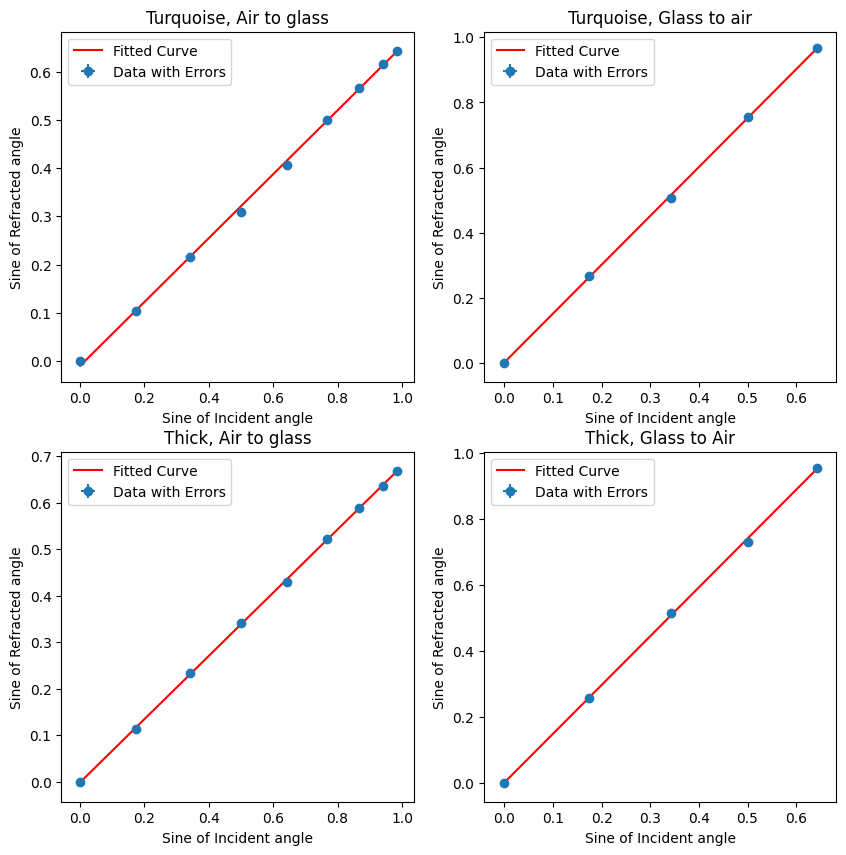

In [66]:
fig, axes = plt.subplots(2, 2, figsize = (10, 10))
for angle_data, ax in zip(angle_data_arr, axes.flatten()):
    angle_data.plot_snell_fit(ax)

And the indices of refractions extracted:


In [68]:
for i, angle_data in enumerate(angle_data_arr):
    n = angle_data.snell_a
    n_err = angle_data.snell_a_err

    if i == 0 or i == 2: ##air to glass interface
        n, n_err = invert_n(n, n_err)
    
    print(f"IOR from {angle_data.sample}, {angle_data.interface}: {n} +/- {n_err}")

IOR from Turquoise, Air to glass: 1.5118017799564436 +/- 0.018299340820822477
IOR from Turquoise, Glass to air: 1.5009351445335313 +/- 0.010844301143787234
IOR from Thick, Air to glass: 1.4708426484726624 +/- 0.01715054718523621
IOR from Thick, Glass to Air: 1.4809244861303068 +/- 0.011194405070079206


In [38]:
## Part 3: Snell

numpy.int32